In [38]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import numpy as np

from SES_setup import *
from utils import *
from style import *
from importlib import reload

plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rc('grid', linestyle="--", color='grey')
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.3
plt.rcParams['lines.linewidth'] = 2.3
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']


colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
colors+=colours

# This code creates figures 1.6, 1.7

In [39]:
w_2 = 1. * ev_to_inv_cm
bias = 0. # 10e-3 * ev_to_inv_cm
V = 15e-3 * ev_to_inv_cm
alpha = 20e-3 * ev_to_inv_cm
T_EM = 300.
T_ph = 300.
Gamma_EM = 7e-7*ev_to_inv_cm # 1ns
#alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
wc = eta/2
w0 = 5*eta # 18e-3*ev_to_inv_cm
Gamma = (w0**2)/wc
print(eta, w0, Gamma, Occupation(w0, T_ph))
N=5


PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=5)

241.965 1209.825 12098.25 0.0030290886648062973


In [40]:

def displace(offset, a):
    return (offset*(a.dag())/sqrt(2) - offset.conjugate()*a/sqrt(2)).expm()

def undisplaced_initial(init_sys, PARAMS):
    n1 = Occupation(PARAMS['w0_1'], PARAMS['T_1'])
    n2 = Occupation(PARAMS['w0_2'], PARAMS['T_2'])
    return tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], 
                                              [n1, n2]))
def position_ops(PARAMS):
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    return [tensor(I_sys, (a + a.dag())/sqrt(2)) for a, omega in zip(atemp, [PARAMS['w0_1'], PARAMS['w0_2']])]


def offsets(init_sys, PARAMS):
    energies, states = exciton_states(PARAMS)
    normal_disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    normal_disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']+4*PARAMS['V'])
    coeff_p = (eta + PARAMS['bias'])/(2*eta)
    coeff_m = (eta - PARAMS['bias'])/(2*eta)
    if init_sys == 'dark':
        return states[0], normal_disp_1*coeff_m, normal_disp_2*coeff_p
    elif init_sys == 'bright':
        return states[1], normal_disp_1*coeff_p, normal_disp_2*coeff_m
    elif init_sys == 'ground':
        return OO, 0, 0
    else:
        raise KeyError("Please choose dark, bright or ground")

def displaced_initial(PARAMS, init_sys='dark', silent=False, return_error=False):
    init_state, offset_1, offset_2 = offsets(init_sys, PARAMS)
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    x = position_ops(PARAMS)
    r0 = undisplaced_initial(init_state*init_state.dag(), PARAMS)
    disp = copy.deepcopy(r0)
    for offset, a_ in zip([offset_1, offset_2], atemp):
        d = tensor(I_sys, displace(offset, a_))
        disp =  d * disp * d.dag()
    try:
        error = 100*(abs((disp*x[0]).tr()- offset_1)/offset_1 + abs((disp*x[1]).tr()- offset_2)/offset_2)
        if error>0.5:
            print ("Error in displacement: {:0.8f}%. Predicted {:0.4f} , actual {:0.4f}".format(error, offset_1, (disp*x[0]).tr()))
            print ("Ratio of kBT to Omega: {:0.4f}".format(0.695*PARAMS['T_1']/PARAMS['w0_1']))
            if ((PARAMS['T_1'] != PARAMS['T_2']) or (PARAMS['w0_1'] != PARAMS['w0_2'])):
               print("Ratio of kBT to Omega (2): {:0.4f}".format(0.695*PARAMS['T_2']/PARAMS['w0_2']))
        if return_error:   
            return disp, error
        else:
            return disp
    except:
        return disp


In [41]:
# Fig 1.6

timelist = np.linspace(0, 1.4/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 

def get_CC_dynamics_data():
    dynamics_list = []
    alpha_list = [1e-3, 5e-3, 20e-3]
    print("bias = {}, V = {}, w0 = {}".format(bias, V, w0))
    print("Are these parameters what you expect?")
    for i, alpha in enumerate(alpha_list):
        PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                                  V = V, alpha=alpha*ev_to_inv_cm,
                                  T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                                  silent=True, exc_diff=N)
        H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
        ops = make_expectation_operators(PARAMS)
        energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
        rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
        #rho_0 = states_dict['bright'][3]*states_dict['bright'][3].dag() # Start system in ground vibrational state
        e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
        for nsteps in np.linspace(1000, 5000, 3):
            try:
                options = qt.Options(nsteps=int(nsteps))
                dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                      progress_bar=True, options=options)
                dynamics_list.append(dynamics)
                break
            except Exception as e:
                print("failed... because {}".format(e))
    return timelist, dynamics_list
    


In [42]:
# Fig 1.6
def plot_dark_bright(timelist, dynamics_list, num):
    plt.figure(figsize=(8,6.5))
    alpha_list = [1 , 5, 20]
    for i, dynamics in enumerate(dynamics_list[0:3]):
        l = r"$\alpha=$"+"{}meV".format(alpha_list)
        plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[0], color=colors[i], 
                 label=r"$\alpha=$"+"{}meV".format(alpha_list[i]))
        plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[1], color=colors[i], ls="dashed")

    plt.xlim(0,1.4)
    plt.ylim(0,1)
    plt.ylabel("Population")
    plt.xlabel("Time (ps)")
    plt.legend()
    figname = "PLOTS/PAPER/dynamics_{}_aug.pdf".format(int(num))
    plt.savefig(figname)
    print("fig saved at "+figname)


bias = 0.0, V = 120.9825, w0 = 1209.825
Are these parameters what you expect?
****************************************************************
The operators took 3.8157799243927 and have dimension 75.
Building the RC Liouvillian took 4.456 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 2.3041889667510986 seconds.
Full optical Liouvillian took 0.8724548816680908 seconds.
Chopping reduced the sparsity from 4.966% to 4.966%
10.0%. Run time:  26.84s. Est. time left: 00:00:04:01
20.0%. Run time:  52.39s. Est. time left: 00:00:03:29
30.0%. Run time:  80.07s. Est. time left: 00:00:03:06
40.0%. Run time: 107.07s. Est. time left: 00:00:02:40
50.0%. Run time: 133.81s. Est. time left: 00:00:02:13
60.0%. Run time: 160.89s. Est. time left: 00:00:01:47
70.0%. Run time: 187.99s. Est. time left: 00:00:01:20
80.0%. Run time: 213.54s. Est. time left: 00:00:00:53
90.0%. Run time: 240.29s. Est. time left: 00:00:00:26
Total run time: 266.86s
********************

/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


fig saved at PLOTS/PAPER/dynamics_0_aug.pdf


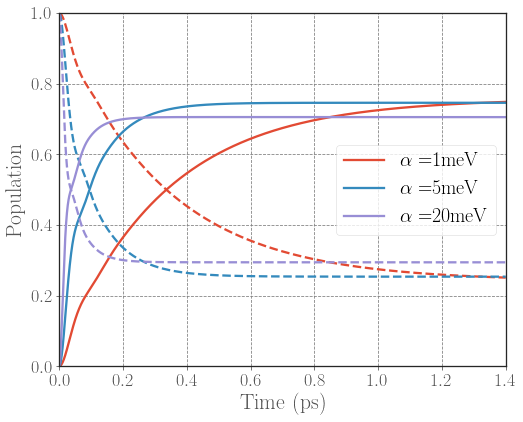

In [43]:
# Fig 1.6a
timelist, dynamics_data1 = get_CC_dynamics_data()
plot_dark_bright(timelist, dynamics_data1, 0)

bias = 120.9825, V = 120.9825, w0 = 1352.6254704393414
Are these parameters what you expect?
****************************************************************
The operators took 4.224179029464722 and have dimension 75.
Building the RC Liouvillian took 4.935 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 2.431364059448242 seconds.
Full optical Liouvillian took 0.9300541877746582 seconds.
Chopping reduced the sparsity from 4.973% to 4.973%
10.0%. Run time:   9.65s. Est. time left: 00:00:01:26
20.0%. Run time:  20.03s. Est. time left: 00:00:01:20
30.0%. Run time:  30.28s. Est. time left: 00:00:01:10
40.0%. Run time:  40.38s. Est. time left: 00:00:01:00
50.0%. Run time:  51.98s. Est. time left: 00:00:00:51
60.0%. Run time:  64.66s. Est. time left: 00:00:00:43
70.0%. Run time:  78.56s. Est. time left: 00:00:00:33
80.0%. Run time:  90.89s. Est. time left: 00:00:00:22
90.0%. Run time: 102.24s. Est. time left: 00:00:00:11
Total run time: 112.68s
****

/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


fig saved at PLOTS/PAPER/dynamics_1_aug.pdf


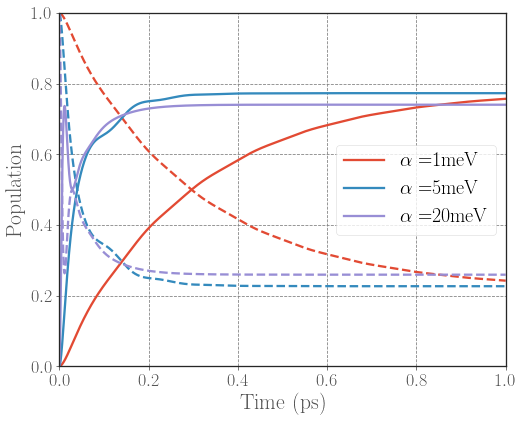

In [33]:
# Fig 1.6b
timelist, dynamics_data1 = get_CC_dynamics_data()
plot_dark_bright(timelist, dynamics_data1, 2)

bias = 120.9825, V = 120.9825, w0 = 1352.6254704393414
Are these parameters what you expect?
****************************************************************
The operators took 9.808068037033081 and have dimension 108.
Building the RC Liouvillian took 12.928 seconds.
It is 11664by11664. The full basis would be 11664by11664
Full optical Liouvillian took 8.710888862609863 seconds.
Full optical Liouvillian took 2.255141019821167 seconds.
Chopping reduced the sparsity from 3.589% to 3.589%
10.0%. Run time:  41.87s. Est. time left: 00:00:06:16
20.0%. Run time:  93.74s. Est. time left: 00:00:06:14
30.0%. Run time: 145.02s. Est. time left: 00:00:05:38
40.0%. Run time: 202.91s. Est. time left: 00:00:05:04
50.0%. Run time: 252.85s. Est. time left: 00:00:04:12
60.0%. Run time: 302.57s. Est. time left: 00:00:03:21
70.0%. Run time: 345.93s. Est. time left: 00:00:02:28
80.0%. Run time: 390.16s. Est. time left: 00:00:01:37
90.0%. Run time: 434.08s. Est. time left: 00:00:00:48
Total run time: 474.90s

/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


fig saved at PLOTS/PAPER/dynamics_3_aug.pdf


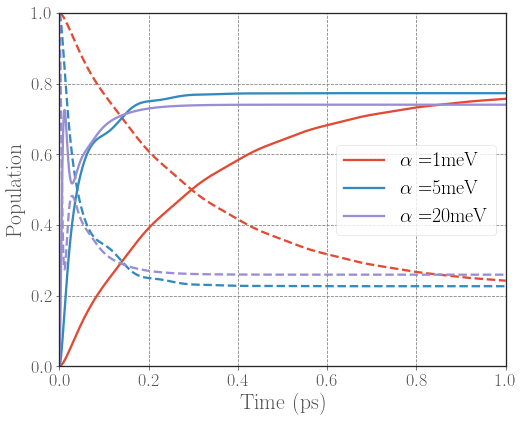

In [41]:
# Fig 1.6b
N=6
timelist, dynamics_data1 = get_CC_dynamics_data()
plot_dark_bright(timelist, dynamics_data1, 3)

In [48]:
# Fig 1.7
# WEAK COUPLING COMPARION VERSION
def get_WC_dynamics_data(bias=0, V = 15e-3*ev_to_inv_cm):
    dynamics_list = []
    dynamics_list_WC = []
    alpha_list = [1e-3, 5e-3, 20e-3]
    eta = gap(bias, V)
    wc = eta/2
    w0 = 5*eta
    Gamma = (w0**2)/wc
    print("bias = {}, V = {}, w0 = {}".format(bias, V, w0))
    print("Are these parameters what you expect?")
    for i, alpha in enumerate(alpha_list):
        PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                                  V = V, alpha=alpha*ev_to_inv_cm,
                                  T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                                  silent=True, exc_diff=N)
        H, L, PARAMS = get_H_and_L(PARAMS,silent=True, threshold=0)
        H_wc, L_wc, _ = get_H_and_L_wc(PARAMS['H_sub'], PARAMS, silent=False, tol=1e-6)
        ops = make_expectation_operators(PARAMS)
        timelist = np.linspace(0, 1.4/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 
        energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
        rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
        #rho_0 = states_dict['bright'][3]*states_dict['bright'][3].dag() # Start system in ground vibrational state
        e_ops = [ops['dark'], ops['bright'], ops['OO'], ops['eig_x'], ops['eig_y']] # List of expectation values to calculate
        
        ops_WC = make_expectation_operators(PARAMS, weak_coupling=True)
        e_ops_WC = [ops_WC['dark'], ops_WC['bright'], ops_WC['OO'], ops_WC['eig_x'], ops_WC['eig_y']]
        for nsteps in np.linspace(1000, 5000, 5):
            try:
                options = qt.Options(nsteps=int(nsteps))
                dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                      progress_bar=True, options=options)
                dynamics_WC = qt.mesolve(H[0], e_ops_WC[1], timelist, c_ops=[L_wc], e_ops=e_ops_WC, 
                                      progress_bar=True, options=options)
                dynamics_list.append(dynamics)
                dynamics_list_WC.append(dynamics_WC)
                break # If the dynamics are successful, don't try any more nsteps
            except Exception as e:
                print("failed... because {}".format(e))
    return timelist, dynamics_list, dynamics_list_WC

In [53]:
def plot_WC_dynamics(timelist, dynamics_list, dynamics_list_WC, num):
    plt.figure(figsize=(8,6.5))
    alpha_list = [1 , 5, 20]
    for i, dynamics in enumerate(zip(dynamics_list[0:3], dynamics_list_WC[0:3])):
        # 
        l = r"$\alpha=$"+"{}meV".format(alpha_list)
        plt.plot(timelist*inv_ps_to_inv_cm, dynamics[0].expect[1], color=colors[i], 
                 label=r"$\alpha=$"+"{}meV".format(alpha_list[i]))
        plt.plot(timelist*inv_ps_to_inv_cm, dynamics[1].expect[1], color=colors[i], ls="dotted")
    plt.xlim(0,1.4)
    #plt.ylim(0,1)
    plt.ylabel("Population")
    plt.xlabel("Time (ps)")
    plt.legend()
    figname = "PLOTS/PAPER/dynamics_WC_{}.pdf".format(int(num))
    plt.savefig(figname)
    print("Fig saved at "+figname)

def plot_WC_coherences(timelist, dynamics_list, dynamics_list_WC, num):
    plt.figure(figsize=(8,6.5))
    alpha_list = [1 , 5, 20]
    for i, dynamics in enumerate(zip(dynamics_list[0:3], dynamics_list_WC[0:3])):
        # 
        l = r"$\alpha=$"+"{}meV".format(alpha_list)
        plt.plot(timelist*inv_ps_to_inv_cm, dynamics[0].expect[3], color=colors[i], 
                 label=r"$\alpha=$"+"{}meV".format(alpha_list[i]))
        plt.plot(timelist*inv_ps_to_inv_cm, dynamics[1].expect[4], color=colors[i], ls="dotted")
    plt.xlim(0,1.4)
    #plt.ylim(0,1)
    plt.ylabel("Coherence")
    plt.xlabel("Time (ps)")
    plt.legend()
    figname = "PLOTS/PAPER/dynamics_coherences_{}.pdf".format(int(num))
    plt.savefig(figname)
    print("Fig saved at "+figname)

In [50]:
timelist, dynamics_list, dynamics_list_WC = get_WC_dynamics_data(bias=0, V = 15e-3*ev_to_inv_cm)


bias = 0, V = 120.9825, w0 = 1209.825
Are these parameters what you expect?
Full optical Liouvillian took 0.009119987487792969 seconds.
It took 0.017004966735839844 seconds to build the phenomenological Liouvillian
WC non-secular and secular dissipators calculated in 64.11604571342468 seconds
10.0%. Run time:  27.09s. Est. time left: 00:00:04:03
20.0%. Run time:  52.50s. Est. time left: 00:00:03:29
30.0%. Run time:  77.98s. Est. time left: 00:00:03:01
40.0%. Run time: 103.12s. Est. time left: 00:00:02:34
50.0%. Run time: 128.76s. Est. time left: 00:00:02:08
60.0%. Run time: 153.92s. Est. time left: 00:00:01:42
70.0%. Run time: 179.10s. Est. time left: 00:00:01:16
80.0%. Run time: 204.07s. Est. time left: 00:00:00:51
90.0%. Run time: 229.07s. Est. time left: 00:00:00:25
Total run time: 253.93s
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.07s. Est. time left: 00:00:00:00
30.0%. Run time:   0.11s. Est. time left: 00:00:00:00
40.0%. Run time:   0.15s. Est. tim

/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Fig saved at PLOTS/PAPER/dynamics_WC_2.pdf


/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Fig saved at PLOTS/PAPER/dynamics_coherences_2.pdf


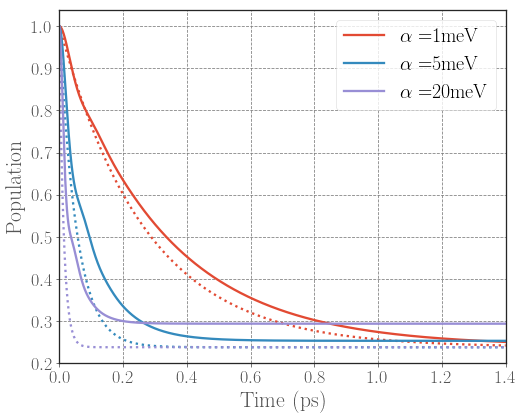

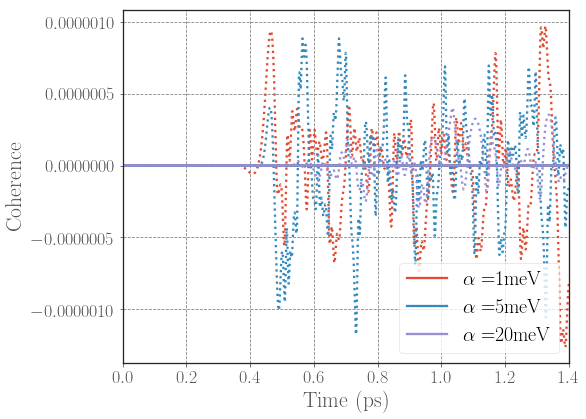

In [54]:
plot_WC_dynamics(timelist, dynamics_list, dynamics_list_WC, 2)
plot_WC_coherences(timelist, dynamics_list, dynamics_list_WC, 2)

In [55]:
# Rerun get_WC_dynamics_data()
w_2 = 1. * ev_to_inv_cm
bias = 15e-3 * ev_to_inv_cm
V = 15e-3 * ev_to_inv_cm
alpha = 20e-3 * ev_to_inv_cm
T_EM = 300.
T_ph = 300.
Gamma_EM = 7e-7*ev_to_inv_cm # 1ns
#alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
wc = eta/2
w0 = 5*eta # 18e-3*ev_to_inv_cm
Gamma = (w0**2)/wc
print(eta, w0, Gamma, Occupation(w0, T_ph))

270.5250940878683 1352.6254704393414 13526.254704393412 0.0015248050937201906


In [56]:
timelist, dynamics_list2, dynamics_list_WC2 = get_WC_dynamics_data(bias=15e-3*ev_to_inv_cm, V = 15e-3*ev_to_inv_cm)

bias = 120.9825, V = 120.9825, w0 = 1352.6254704393414
Are these parameters what you expect?
Full optical Liouvillian took 0.007866859436035156 seconds.
It took 0.019935131072998047 seconds to build the phenomenological Liouvillian
WC non-secular and secular dissipators calculated in 68.91237902641296 seconds
10.0%. Run time:  28.51s. Est. time left: 00:00:04:16
20.0%. Run time:  59.13s. Est. time left: 00:00:03:56
30.0%. Run time:  90.89s. Est. time left: 00:00:03:32
40.0%. Run time: 122.75s. Est. time left: 00:00:03:04
50.0%. Run time: 151.56s. Est. time left: 00:00:02:31
60.0%. Run time: 179.09s. Est. time left: 00:00:01:59
70.0%. Run time: 207.36s. Est. time left: 00:00:01:28
80.0%. Run time: 235.44s. Est. time left: 00:00:00:58
90.0%. Run time: 263.81s. Est. time left: 00:00:00:29
Total run time: 292.25s
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.07s. Est. time left: 00:00:00:00
30.0%. Run time:   0.11s. Est. time left: 00:00:00:00
40.0%. Run time: 

In [58]:
save_obj([timelist, dynamics_list2, dynamics_list_WC2], 'DATA/dynamics_data_1')

/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Fig saved at PLOTS/PAPER/dynamics_WC_3.pdf


/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Fig saved at PLOTS/PAPER/dynamics_coherences_3.pdf


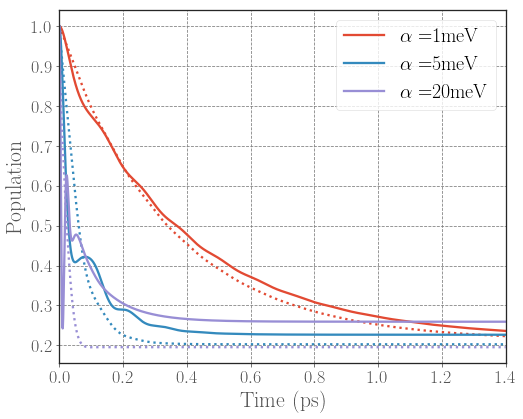

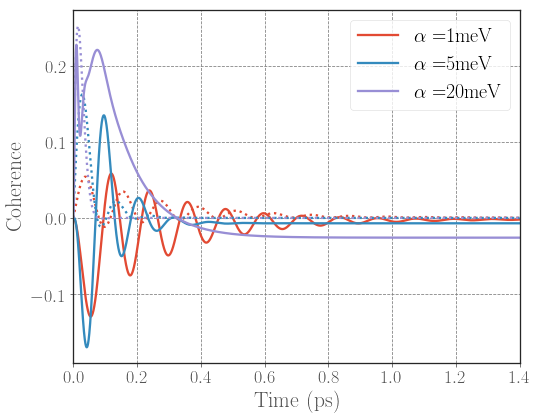

In [57]:
plot_WC_dynamics(timelist, dynamics_list2, dynamics_list_WC2, 3)
plot_WC_coherences(timelist, dynamics_list2, dynamics_list_WC2, 3)

In [ ]:
# OLD

bias = 120.9825, V = 120.9825, w0 = 1352.6254704393414
Are these parameters what you expect?
Full optical Liouvillian took 0.009050846099853516 seconds.
It took 0.014467000961303711 seconds to build the phenomenological Liouvillian
WC non-secular and secular dissipators calculated in 63.616986989974976 seconds
10.0%. Run time:  46.17s. Est. time left: 00:00:06:55
20.0%. Run time:  98.90s. Est. time left: 00:00:06:35
30.0%. Run time: 149.53s. Est. time left: 00:00:05:48
40.0%. Run time: 210.54s. Est. time left: 00:00:05:15
50.0%. Run time: 261.10s. Est. time left: 00:00:04:21
60.0%. Run time: 308.73s. Est. time left: 00:00:03:25
70.0%. Run time: 349.25s. Est. time left: 00:00:02:29
80.0%. Run time: 390.16s. Est. time left: 00:00:01:37
90.0%. Run time: 430.83s. Est. time left: 00:00:00:47
Total run time: 472.64s
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.05s. Est. time left: 00:00:00:00
30.0%. Run time:   0.08s. Est. time left: 00:00:00:00
40.0%. Run time:

/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


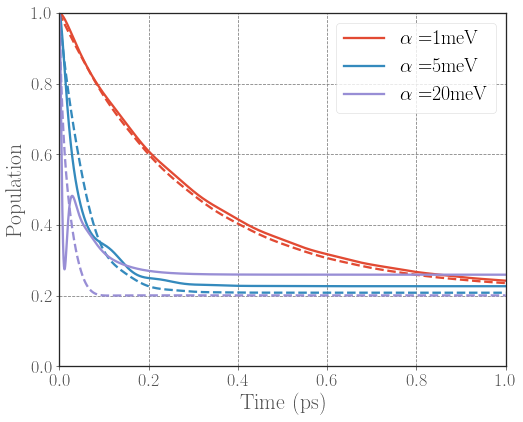

In [42]:
timelist, dynamics_list2, dynamics_list_WC2 = get_WC_dynamics_data()
plot_WC_dynamics(timelist, dynamics_list2, dynamics_list_WC2, 2)

# BIASED
It appears that unbiased dimers do not lead to dark-state population enhancement (for Redfield). This could be something to do with the lack of exciton coherence

In [ ]:
w_2 = 1. * ev_to_inv_cm
bias = 15e-3 * ev_to_inv_cm
V = 15e-3 * ev_to_inv_cm
alpha = 20e-3 * ev_to_inv_cm
T_EM = 300.
T_ph = 300.
Gamma_EM = 7e-7*ev_to_inv_cm # 1ns
#alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
wc = eta
w0 = 5*eta # 18e-3*ev_to_inv_cm
Gamma = (w0**2)/wc
print(eta, w0, Gamma, Occupation(w0, T_ph))
N=5


PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=5)

dynamics_list2 = []
dynamics_list_WC2 = []
alpha_list = [1e-3, 5e-3, 20e-3]

for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    H_wc, L_wc, _ = get_H_and_L_wc(PARAMS['H_sub'], PARAMS, silent=False, tol=1e-7)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(0, 1/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    #rho_0 = states_dict['bright'][3]*states_dict['bright'][3].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    energies_wc, states_wc = exciton_states(PARAMS, shift=False)
    dark_wc, bright_wc = states_wc[0]*states_wc[0].dag(), states_wc[1]*states_wc[1].dag()
    e_ops_wc = [dark_wc, bright_wc]
    for nsteps in np.linspace(1000, 5000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_WC = qt.mesolve(H[0], bright_wc, timelist, c_ops=[L_wc], e_ops=e_ops_wc, 
                                  progress_bar=True, options=options)
            dynamics_list2.append(dynamics)
            dynamics_list_WC2.append(dynamics_WC)
            break
        except Exception as e:
            print("failed... because {}".format(e))

270.5250940878683 1352.6254704393414 6763.127352196706 0.0015248050937201906
****************************************************************
The operators took 4.106438875198364 and have dimension 75.
Building the RC Liouvillian took 4.754 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 2.433203935623169 seconds.
Full optical Liouvillian took 0.8920879364013672 seconds.
Chopping reduced the sparsity from 4.973% to 4.973%
Full optical Liouvillian took 0.01143503189086914 seconds.
It took 0.021126985549926758 seconds to build the phenomenological Liouvillian
WC non-secular and secular dissipators calculated in 295.1271970272064 seconds
could calculate:
dict_keys(['OO', 'XO', 'OX', 'site_coherence', 'bright', 'dark', 'eig_x', 'eig_y', 'eig_z', 'eig_x_equiv', 'sigma_x', 'sigma_y', 'sigma_z', 'RC1_position1', 'RC2_position', 'RC1_number', 'RC2_number'])
8.0655 10
1000.0
10.0%. Run time:   9.99s. Est. time left: 00:00:01:29
20.0%. Run time:  20.38

In [53]:
dynamics_list2 = []
alpha_list = [1e-3, 5e-3, 20e-3]

for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(0, 1/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    #rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    rho_0 = states_dict['bright'][3]*states_dict['bright'][3].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    for nsteps in np.linspace(1000, 5000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_list1.append(dynamics)
            break
        except Exception as e:
            print("failed... because {}".format(e))

****************************************************************
The operators took 4.69381904602 and have dimension 75.
Building the RC Liouvillian took 5.383 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 2.89857697487 seconds.
Full optical Liouvillian took 1.09299683571 seconds.
Chopping reduced the sparsity from 4.966% to 4.966%
could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
(8.0655, 10)
1000.0
10.0%. Run time:  11.41s. Est. time left: 00:00:01:42
20.0%. Run time:  21.81s. Est. time left: 00:00:01:27
30.0%. Run time:  33.47s. Est. time left: 00:00:01:18
40.0%. Run time:  43.72s. Est. time left: 00:00:01:05
50.0%. Run time:  53.10s. Est. time left: 00:00:00:53
60.0%. Run time:  62.43s. Est. time left: 00:00:00:41
70.0%. Run time:  71.60s. Est. time left: 00:00:00:30
80.0%. Run tim

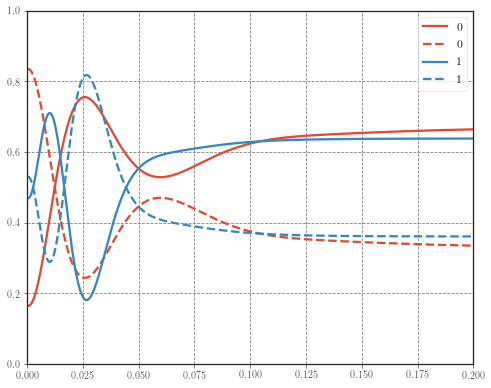

In [66]:
plt.figure(figsize=(8,6.5))
for i, dynamics in enumerate(dynamics_list1[4::]):
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[0], color=colors[i], label=i)
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[1], color=colors[i], ls="dashed", label=i)

plt.xlim(0,0.2)
plt.ylim(0,1)
plt.legend()


In [68]:
dynamics_list2 = []
alpha_list = [1e-3, 5e-3, 20e-3]

for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(0, 1/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    #rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    rho_0 = states_dict['bright'][1]*states_dict['bright'][1].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    for nsteps in np.linspace(1000, 5000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_list2.append(dynamics)
            break
        except Exception as e:
            print("failed... because {}".format(e))

****************************************************************
The operators took 5.11890101433 and have dimension 75.
Building the RC Liouvillian took 5.818 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 2.75110507011 seconds.
Full optical Liouvillian took 1.19549298286 seconds.
Chopping reduced the sparsity from 4.966% to 4.966%
could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
(8.0655, 10)
1000.0
10.0%. Run time:  17.82s. Est. time left: 00:00:02:40
20.0%. Run time:  34.58s. Est. time left: 00:00:02:18
30.0%. Run time:  51.25s. Est. time left: 00:00:01:59
40.0%. Run time:  67.86s. Est. time left: 00:00:01:41
50.0%. Run time:  84.59s. Est. time left: 00:00:01:24
60.0%. Run time: 101.23s. Est. time left: 00:00:01:07
70.0%. Run time: 119.10s. Est. time left: 00:00:00:51
80.0%. Run tim

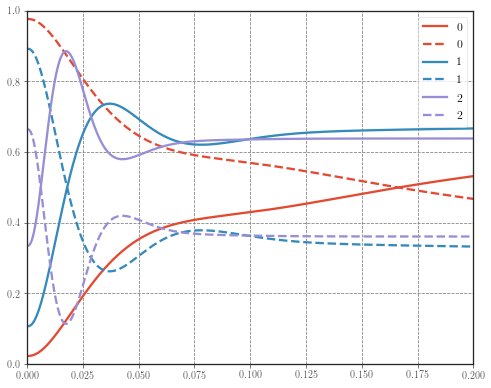

In [69]:
plt.figure(figsize=(8,6.5))
for i, dynamics in enumerate(dynamics_list2):
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[0], color=colors[i], label=i)
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[1], color=colors[i], ls="dashed", label=i)

plt.xlim(0,0.2)
plt.ylim(0,1)
plt.legend()

In [136]:
1/0.0375, 1/0.075

(26.666666666666668, 13.333333333333334)

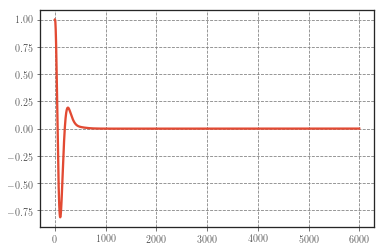

In [127]:
dyn_dat = dynamics_list2[2].expect[0] - dynamics_list2[2].expect[0][-1]
dyn_dat/=dyn_dat[0]
plt.plot(dyn_dat)

In [128]:
spec = sp.fftpack.fft(dyn_dat)
dt = (timelist[1]-timelist[0])
freq = 2 * pi * np.array(sp.fftpack.fftfreq(spec.size, dt))
spec = 2 * dt* np.real(spec)
spec-= min(spec)
spec = spec/sum(spec)
freq, spec = zip(*sorted(zip(freq, np.array(spec).real)))

In [116]:
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) #

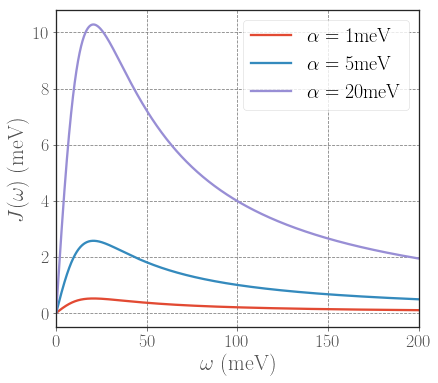

In [51]:
def plot_UD_SD_PARAMS(PARAMS, ax=None):
    eps = gap(PARAMS['bias'], PARAMS['V'])*10
    alpha = PARAMS['alpha_2']
    w_0 = PARAMS['w0_2']
    Omega = np.linspace(0.,eps,10000)
    J_w = np.array([J_underdamped(w, alpha, w_0, Gamma=Gamma) for w in Omega])
    show_im = ax
    if ax is None:
        f, ax = plt.subplots(1,1)
    ax.plot(1000*Omega/ev_to_inv_cm, 1000*J_w/ev_to_inv_cm, 
            label=r"$\alpha=$ {}meV".format(int(1000*PARAMS['alpha_2']/ev_to_inv_cm)))
    ax.set_xlabel(r"$\omega$ (meV)")
    ax.set_ylabel(r"$J(\omega)$ (meV)")
    #if show_im is None:
    #    plt.show()
    ax.legend()
f, ax = plt.subplots(1,1, figsize=(6.5,5.1))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.989, wspace=0., hspace=0.02)
PARAMS['alpha_2'] = 1e-3*ev_to_inv_cm
plot_UD_SD_PARAMS(PARAMS, ax=ax)
PARAMS['alpha_2'] = 5e-3*ev_to_inv_cm
plot_UD_SD_PARAMS(PARAMS, ax=ax)
PARAMS['alpha_2'] = 20e-3*ev_to_inv_cm
plot_UD_SD_PARAMS(PARAMS, ax=ax)
ax.set_xlim(0,200)
plt.savefig("PLOTS/PAPER/overdampedSDs.pdf")

# Long time dynamics

In [4]:
dynamics_list_lt = []
alpha_list = [1e-3, 5e-3, 20e-3]
N=4
for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(1/inv_ps_to_inv_cm, 6000/inv_ps_to_inv_cm, 24000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    #rho_0 = steadystate(H[1], [L['nonadd']])
    #rho_0 = states_dict['bright'][1]*states_dict['bright'][1].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    for nsteps in np.linspace(1000, 15000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_list2.append(dynamics)
            break
        except Exception as e:
            print("failed... because {}".format(e))

****************************************************************
The operators took 1.75271606445 and have dimension 48.
Building the RC Liouvillian took 1.926 seconds.
It is 2304by2304. The full basis would be 2304by2304
Full optical Liouvillian took 1.17902398109 seconds.
Full optical Liouvillian took 0.517604112625 seconds.
Chopping reduced the sparsity from 7.357% to 7.357%
could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
(8.0655, 8)
1000.0


/Users/henrymaguire/.pyenv/versions/2.7.15/lib/python2.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


failed... because ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.
4500.0
failed... because ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.
8000.0



KeyboardInterrupt

